<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/image-classification/Building_Tensorflow_Image_Input_Pipeline_Part_1_Using_tf_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Tensorflow Image Input Pipeline Part 1-Using tf.data

---



## Introduction
---

The Input Data Pipeline is the preprocessing stage of the Neural Network. It operates in an **`ETL`** (**E**xtract, **T**ransform, **L**oad) pipelined process, as depicted in the figure which follows.


**`Input Data Pipeline`:**


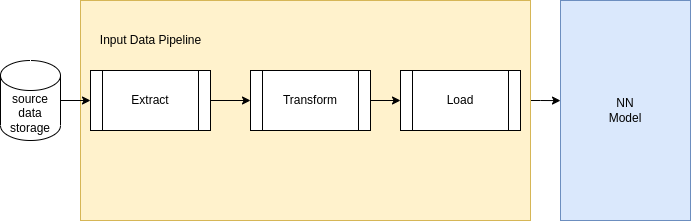

### **Input Data Pipeline Outlines**

---

The **Extract** block fetches data from input data source, which in case of Image Data Networks are most likely data files, arranges them as dataset memory objects in local memory.

The **Transform** block, naturally, transformd the data to create an efficient input data set. Most of the transforms are regarded `Performance Transforms` as they format the data to achieve better compute performance.


The **Load** block transfers the data to the Network's input layer. 



### **Commonly Used Data Transform**
---


- **Image Decoding** - decode either from jpeg or any coding format.
- **Data batching** - batches of data, be it image data or not, are required for an efficient parralelized process in general, and speciffically better exploits GPUs parralelism capabilities.
.
- **Resize** - Networks require uniform sized images only. Since source data images are mostly uniform in size, a `resize` operation is mandatory. Now, which is size to resize to? The answer is not always straight forward and definite. There are tradeoffs such as a tradeoff between details preservation vs compution and memory load. Anyway, we will set dimenssions such that after downsizing both height and width ramain integrer.



- **Normalize** (or better say scale) input data to the range [0,1]. A standardized  data range for all input data is essential for a better model Performance. 

- **Caching** of input data to avoid reloading at each epoch fitting cycle. Large datasets which do not fit in memory, should not be cached.

- **Shuffling** - which randomized the data loading sequence order.
- **Prefetch** which supports concurrent data prefetching and data processing.
- **Data Augmentation** which expands training dataset, increases the diversity of training set, by applying transformations, such as image rotation, flips, shifts.


### **About the series of posts**
---

This page is part of a series posts about **Building An Tensorflow Image Input Pipeline**.

Each post of this series presents one approach for the creation of an input image data pipeline, each uses a different set of APIs.

They differ in aspects such as level of integration (some are more integrated convinience api while others are less integrated but sometimes more flexible), and also differ in terms of efficiency and performance, (the `ImageGenerator` approach proves to be less performant)

Still, all approaches create a tensorflow dataset object which is an itegrated part of the Neural Netork Graph, along with the NN model, thus providing a smooth data integration throughout the process.

### Description of the Posts Contents

Each of the posts illustrates the creation of the input data pipeline in the context of a data classification example, using various data sources: `rock-paper-scissors`, `flowers` and `horses or humans`


### List of the series posts:
---

The posts of this series are: 


- **Building Tensorflow Image Input Pipeline Part 1**: Using tf.data()

- [**Building Tensorflow Image Input Pipeline Part 2**: Using Keras Utils](https://colab.research.google.com/drive/1s3EdMO2uMWQMtqsPxIZOS-cvA4QqfMls#scrollTo=gpz8q177vSBj&uniqifier=2)

- **Building Tensorflow Image Input Pipeline Part 3**: Using ImageGenerator()
- **Building Tensorflow Image Input Pipeline Part 4**: Using TFDS()


Each of the posts illustrates the creation of the dataset within an image classification example. 






###**Notes About this post approach- data pipeline Creation with tf.data**

This approach uses the the fundamental tf.data module. Accordingly it provides less convinience options but is somewhat more flexible.

### Rock Paper Scissors
---

The input data used in this example is the `Rock Paper Scissors` dataset, listed in [TensorFlow Datasets catalog](https://www.tensorflow.org/datasets/catalog/overview). The dataset was produced by [Lawrance Moroney](https://laurencemoroney.com/datasets.html), million thanks for him on that.

**Let's go dive into the code!**


## 1. Import Packages
---


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import random


## 2. Download the data
---

- Download the dataset to local platform. 

- Data is packed in a .zip file. 

- When `extract=True` packed data is extracted



In [2]:
import pathlib
dataset_name = 'rps'
dataset_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip'
dataset_file = tf.keras.utils.get_file(origin=dataset_url, fname=dataset_name+'.zip', extract=True)

200695808/200682221 [==============================] - 2s 0us/step


**Print locally stored file path:**

In [3]:
print(dataset_file)

/root/.keras/datasets/rps.zip


The downloaded zip file file was extracted , due to the `extract=True` attribute.

Let's examine the zip file and the extracted directory: 

In [4]:
import os
dataset_dir = pathlib.Path(os.path.dirname(os.path.abspath(dataset_file)))
!ls $dataset_dir

rps  rps.zip


#### Each dataset subdirectory to a data class: paper  rock  scissors. Here's the subdirectory list:


In [5]:
subdir_names = [f for f in os.listdir(os.path.join(dataset_dir, dataset_name))]
print(subdir_names)

['scissors', 'paper', 'rock']


The zip file downloaded so far holds the `training` data. 

The dataset's author composed another zip file which holds the `test` data. 

Next download it:

In [6]:
dataset_test_name = 'rps_test'
dataset_test_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip'
dataset_test_file = tf.keras.utils.get_file(origin=dataset_test_url, fname=dataset_test_name+'.zip', extract=True)

29532160/29516758 [==============================] - 0s 0us/step


**Merge Train and Test Data**
---


The `train` and `test` datasection are pre-split 80-20. Normally, that would be fine. 

But, methodicaly, to demonstrate slicing to `train` and `validate` slices later on, we will now merge the 2 downloaded splits, and have a single big data source.

In [7]:
!cp -r /root/.keras/datasets/rps-test-set/* /root/.keras/datasets/rps

Let's check how much data have we got by counting number of files in each class directory

In [8]:
from os import listdir
from os.path import isfile, join
import os

class_dir_info = {}
file_ext = 'png'

base_data_dir = os.path.join(dataset_dir, 'rps')
for subdir_name in subdir_names:
  subdir = pathlib.Path(os.path.join(base_data_dir, subdir_name))
  files_count = len([file for file in os.listdir(subdir) if file.endswith(file_ext)])
  class_dir_info.update({'dir': subdir})
  print('{}: {} files'.format(subdir_name, files_count))

image_count = len(list(pathlib.Path(base_data_dir).glob('*/*.{}'.format(file_ext))))
print('total file count: {}'.format(image_count))

scissors: 964 files
paper: 964 files
rock: 964 files
total file count: 2892


***Visualization*** - take a brief look at randomly selected images from each class

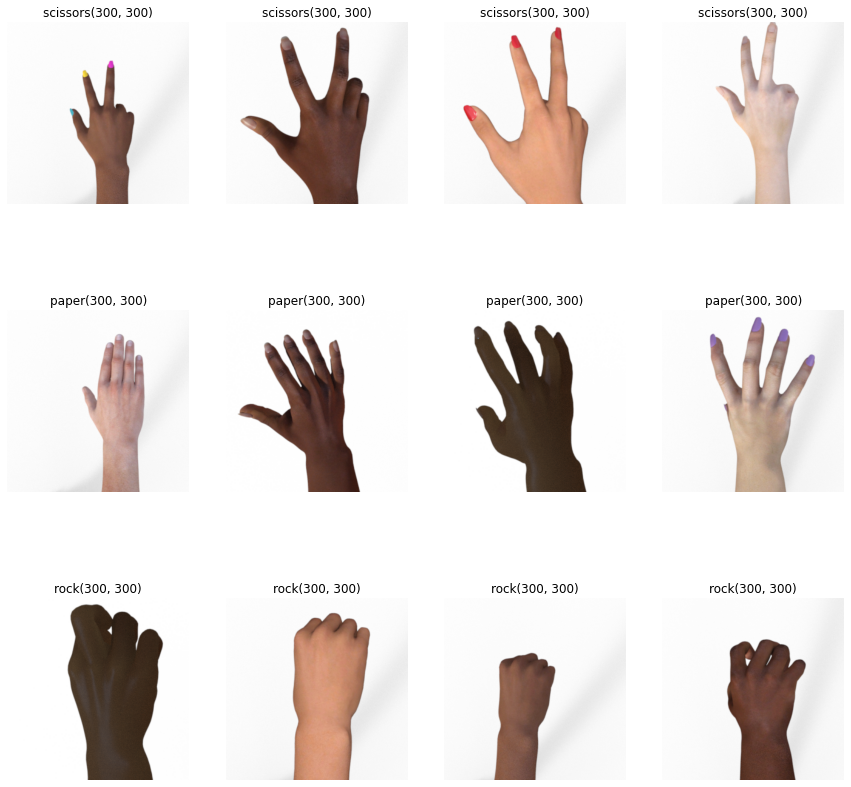

In [9]:
plt.figure(figsize=(15, 15))
cnt = 0
for i, subdir_name in enumerate(subdir_names):
  path = pathlib.Path(os.path.join(base_data_dir, subdir_name))
  for j in range(4):
    cnt +=1
    ax = plt.subplot(3, 4, cnt)
    filename =random.choice(os.listdir(path))
    img = PIL.Image.open(os.path.join(path, filename))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(subdir_names[i]+str(img.size))

## 3. Create the Data Pipeline
---


####**Some Values Setup**


- **batch size**: A batch size of 32 is a good starting point. There's a trade-off here, were a too small batch size might lead to a too slow processing due to lacking vectorization. A too large batch might leads to low accuracy and thus longer training time.


In [10]:
batch_size = 32


- **image_height**, **image_width**: The are tradeoffs in setting the input dimenssions: keeping details vs process load. Anyway, since source data image is mostly none size uniform, resizing is essential. Since the NN deployed here has 5 pooling modules, which reduce size overall by 32, the size was set to a multiply of 32.

In [11]:
image_height = 224
image_width = 224

####**Create a dataset list of files**

We start by composing a dataset list of all files. 

The labels will later be extracted from path name - according to subdirectory name.

---
**Important Note**: 
---
The list_files() is invoked with **shuffle=False**. Otherwise, the dataset will be suffled among all split slices, such that a train sample ma be part of the test slice in another epoch.

The shuffle is provisioned with the shuffle() api assigned with the attribute reshuffle_each_iteration=False

In [12]:
base_data_dir = pathlib.Path(base_data_dir)
list_ds = tf.data.Dataset.list_files(str(base_data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

####**Print some of the list entries:**

In [13]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/rps/paper/paper05-112.png'
b'/root/.keras/datasets/rps/paper/paper01-110.png'
b'/root/.keras/datasets/rps/scissors/testscissors01-06.png'
b'/root/.keras/datasets/rps/scissors/scissors02-071.png'
b'/root/.keras/datasets/rps/rock/rock04-070.png'


####**Split dataset to training and validation**

It's a 'free style' code, so , btw, we might have made a `test data` split - but we will compose a test data using another data source, so to perform a more independent test.

In [14]:
train_size = int(len(list_ds) * 0.8)
print('train_size:',train_size)
train_ds = list_ds.take(train_size)
val_ds = list_ds.skip(train_size)

train_size: 2313


####**Print datasets Cardinality**

In [15]:
print('train dataset: ', tf.data.experimental.cardinality(train_ds).numpy())
print('validation dataset: ',tf.data.experimental.cardinality(val_ds).numpy())

train dataset:  2313
validation dataset:  579


####**Extract class names from subdir names.**

The sorting is not essential, but it provides a deterministic order. 


In [16]:
class_names = np.array(sorted([item.name for item in base_data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['paper' 'rock' 'scissors']


####**Create the dataset**

- Extract class name from path's subdirectory name field

- Encode class name by an int label, according to class_names position, e.g. 'paper' encoded to 0, 'rock' to 1 and scissors to 2. 

- Read image file

- Decode png format (or jpeg etc, according to data source format)

- Resize image

- Batch dataset


In [17]:
def process_path(file_path):
  one_hot_label = tf.strings.split(file_path, os.sep)[-2] == class_names
  label = tf.argmax(one_hot_label)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def decode_img(img):
  # Convert the png to uint8 encode, 3D tensor
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [image_height, image_width])

train_ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=False)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=False)

## 4. Configure Dataset for Performance
---


**Configure the Dataset for Performance**

Some essential data transformations were already performed by `image_dataset_from_directory`. 

That includes **`batching`**, **`image format decoding`**, **`splitting`** and `resizing`.

Those transformation were essential for the execution of the network.


Next transormations are needed to improve performance:


- **cache** -  keeps the images in memory after they're loaded off disk during 
the first epoch.

- **shuffle** - fills a buffer with buffer_size elements, then randomly samples elements from this buffer. The sampled elements are replaced by new dataset elements as depicted in the diagram below. 

- **prefetch** -  overlaps data preprocessing and model execution while training. (The tf.data.AUTOTUNE parameter defines a dynamic tuning of the number of prefetched data elements. The number depends on the number of batches consumed in a single step, i.e. on parallelism extent). In case both **perfecth** and **shuffle** are set, the shuffle buffer should be greater than or equal to the full size of the dataset.

- **normalization** - standardizes the inputs to the range [0,1], which improves performance.


- **augmentation** - expands training dataset, increases the diversity of training set, by applying transformations, such as image rotation, flips, shifts, and shear.




In [18]:
train_ds = train_ds.cache().shuffle(buffer_size=tf.data.experimental.cardinality(train_ds).numpy(), seed=None, reshuffle_each_iteration=None, name=None).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

**Normalize the data**

Standardizes the inputs. This is often integrated within the model, but can also be set on the dataset like so:

In [19]:
normalization_layer = layers.Rescaling(1./255)

In [20]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

**Data Augmentation** - Expand training dataset size

(Find details on Data Augmentation in a related post (TBD))

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
    layers.RandomRotation(0.9, fill_mode="nearest",),
    layers.RandomZoom(0.1),
  ]
)

**Demonstrate Augmentation Visualization**: 

Here's how the augmented images look like

- Original image is at upper left

- 8 randomly augmented images. 


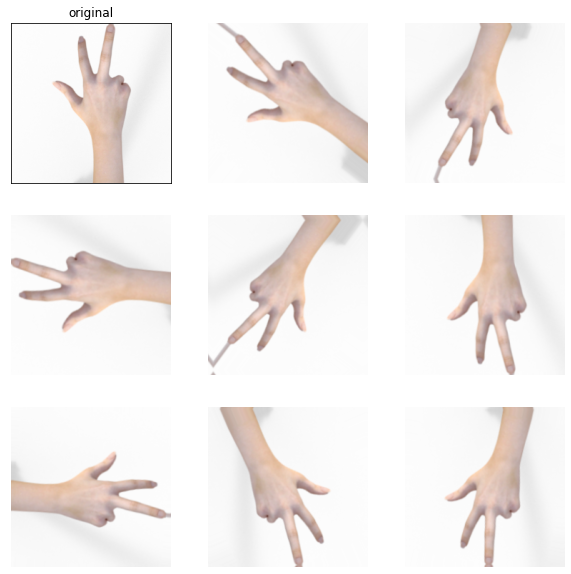

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  image = images[random.randint(0, len(images)-1)]
  ax = plt.subplot(3, 3, 1)
  ax.set_title('original')
  plt.imshow(image)
  ax.set_xticks([])
  ax.set_yticks([])

  for i in range(8):
    augmented_images = data_augmentation((tf.expand_dims(image, axis=0, name=None)))
    ax = plt.subplot(3, 3, i + 2)
    plt.imshow(augmented_images[0].numpy().astype("float32"))
    plt.axis("off")

Set Augmentation to training dataset

In [23]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

####**Present Train Dataset**

Present just a fraction of the dataset...

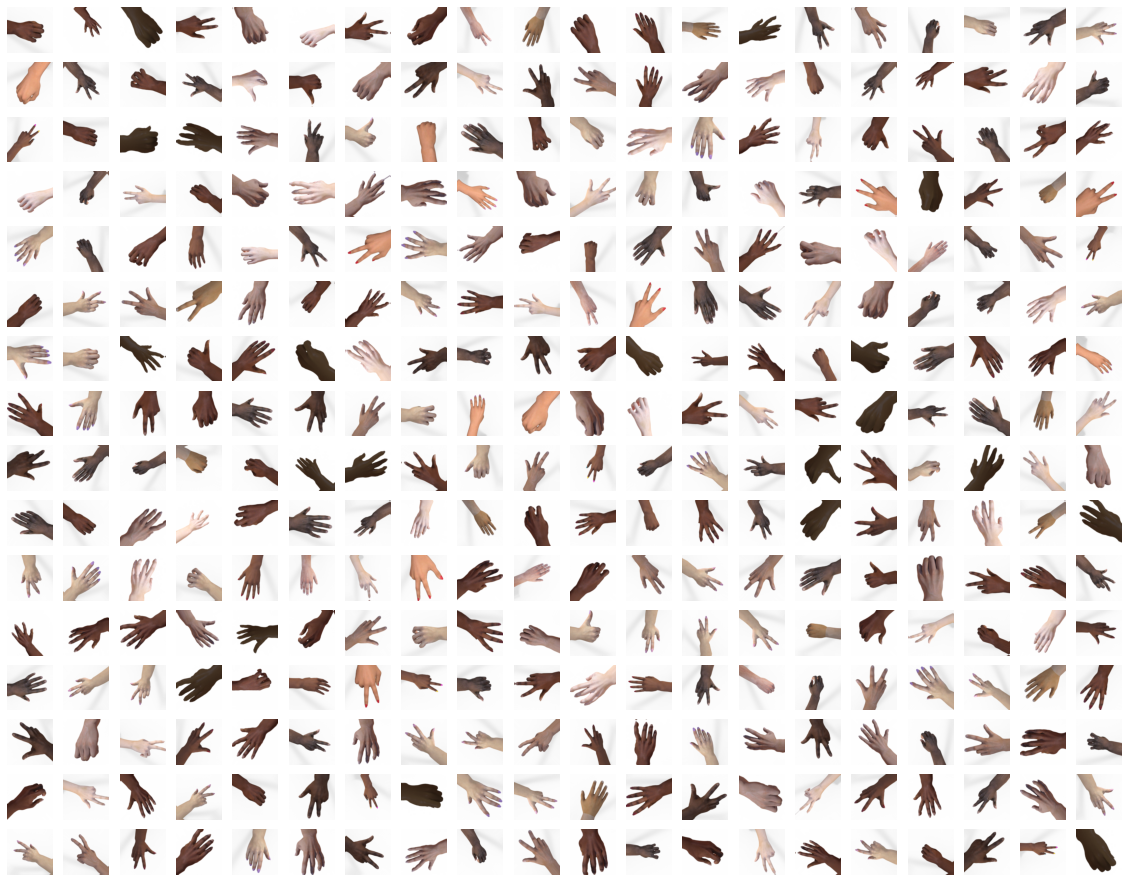

In [24]:
plt.figure(figsize=(20, 20))
batches_in_loop = 10
cnt = 0
for j in range(batches_in_loop):
  image_batch, _ = next(iter(train_ds))
  for i in range(32):
    cnt +=1
    ax = plt.subplot(20, 20, cnt)
    # print(i)
    plt.imshow(image_batch[i])
    plt.axis("off")

## 5. Set the model
---


The model consists of 7 layers:
- It begins with 5 convolution blocks, each followed by a max pooling module.

- Then, after flattening the data, convolution blocks are followed by 2 dense layers: 
 - A 128 units dense layer
 - The output layer, with 3 units according to the 3 output classes, i.e.rock, paper, scizors.


In [25]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes,  activation = 'softmax')
])

<a name='5'></a>
## 6. Compile the Model
---


- optimizer `adam` - a commonly used stochastic adaptive optimizer.  
- loss function `SparseCategoricalCrossentropy` - commonly used for image classification with more than 2 classes
- from_logits=True - This indicate the loss function that that the output is not normalized, i.e. there is no softmax function at the output. BTW, excluding the softmax function from the model, is considered more numerically stable. The softamx is then added by the loss function module.


In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## 7. Train the model
---


**Set an Early Stopping Callback:**

- Stop training when a monitored metric has stopped improving.

- Wait before stopping according `patience` value.

- Restore best waits, after stopping



In [27]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=10, 
                                verbose=1, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)

Now do the fit - 30 epochs, with early_stop_cb.

In [28]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop_cb],
)

Epoch 1/30
91/91 [==============================] - 42s 363ms/step - loss: 1.1133 - accuracy: 0.3427 - val_loss: 1.0458 - val_accuracy: 0.5561
Epoch 2/30
91/91 [==============================] - 31s 342ms/step - loss: 0.9781 - accuracy: 0.5055 - val_loss: 0.7328 - val_accuracy: 0.6770
Epoch 3/30
91/91 [==============================] - 31s 344ms/step - loss: 0.6754 - accuracy: 0.7006 - val_loss: 0.3740 - val_accuracy: 0.8601
Epoch 4/30
91/91 [==============================] - 31s 341ms/step - loss: 0.4303 - accuracy: 0.8150 - val_loss: 0.2924 - val_accuracy: 0.8722
Epoch 5/30
91/91 [==============================] - 31s 338ms/step - loss: 0.3211 - accuracy: 0.8748 - val_loss: 0.3229 - val_accuracy: 0.8739
Epoch 6/30
91/91 [==============================] - 31s 341ms/step - loss: 0.2225 - accuracy: 0.9139 - val_loss: 0.1993 - val_accuracy: 0.9378
Epoch 7/30
91/91 [==============================] - 31s 337ms/step - loss: 0.1994 - accuracy: 0.9319 - val_loss: 0.0829 - val_accuracy: 0.9706

## 8. Display model summary
---


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)     

## 9 Visualize Training Results
---


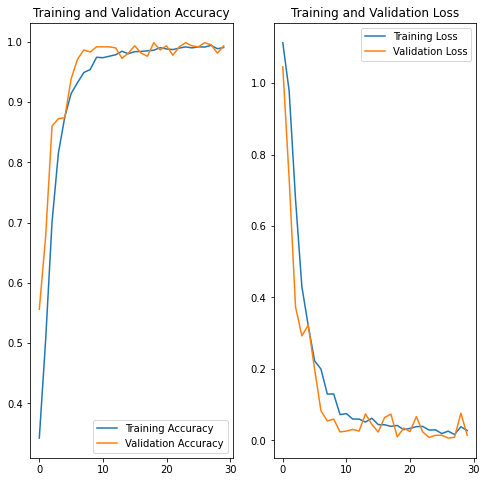

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 10. Inference
---


The train model will now be tested with test data.

1. Inference with test dataset downloaded from `Kaggle`. 

2. Inference with interactively uploaded test dataset

### Inference with test dataset from `Kaggle`
---


**In this section, the following stages are executed:**
  - **Upload `Kaggle` Auth token** - required before the dataset download from `Kaggle` is authorized.
  - **Download the test dataset from `Kaggle`**
  - **Run `model.predict` over the test dataset**
  - **Run `model.evaluate` over the test dataset**

  
  And then:
  
  **Coments on Inference Results**


**Uppload Kaggle Auth Token**

The kaggle auth token is stored in a file called `kaggle.json`.


If you have already a `kaggle.json` file, the code in the notebook cell which follows will upload it (click on `Choose Files`).
 
If you don't, you can generate one - click [here](https://ronen-halevy.github.io/2021/11/15/kaggle-api-settings.html) for a post on setting Kaggle API.



**Download the test dataset from Kaggle**

In [31]:
from google.colab import files

uploaded = files.upload()
  
# Move kaggle.json into ~/.kaggle:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json



**Download the test dataset from Kaggle and unzip it**

In [32]:
!kaggle datasets download -d ronenhalevy/rps-test
!unzip rps-test.zip

  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 28.8MB/s]
Archive:  rps-test.zip
  inflating: rps_test/paper/papaer9.jpg  
  inflating: rps_test/paper/papar10.jpg  
  inflating: rps_test/paper/paper-2.jpg  
  inflating: rps_test/paper/paper3.jpg  
  inflating: rps_test/paper/paper6.jpg  
  inflating: rps_test/rock/rock.jpg  
  inflating: rps_test/rock/rock3.jpg  
  inflating: rps_test/rock/rock4.jpg  
  inflating: rps_test/rock/rock5.jpg  
  inflating: rps_test/rock/rock7.jpg  
  inflating: rps_test/rock/rock8.jpg  
  inflating: rps_test/rock/sn-rock.jpg  
  inflating: rps_test/scissors/scisors.jpg  
  inflating: rps_test/scissors/scissors3.jpg  
  inflating: rps_test/scissors/scissors4.jpg  
  inflating: rps_test/scissors/scissors5.jpg  
  inflating: rps_test/scissors/scissors6.jpg  
  inflating: rps_test/scissors/scissors7.jpg  
  inflating: rps_test/scissors/scissors8.jpg  
  inflating: rps_test/scissors/sn-scissors.jpg  


**Run `model.predict` over the test dataset**
---




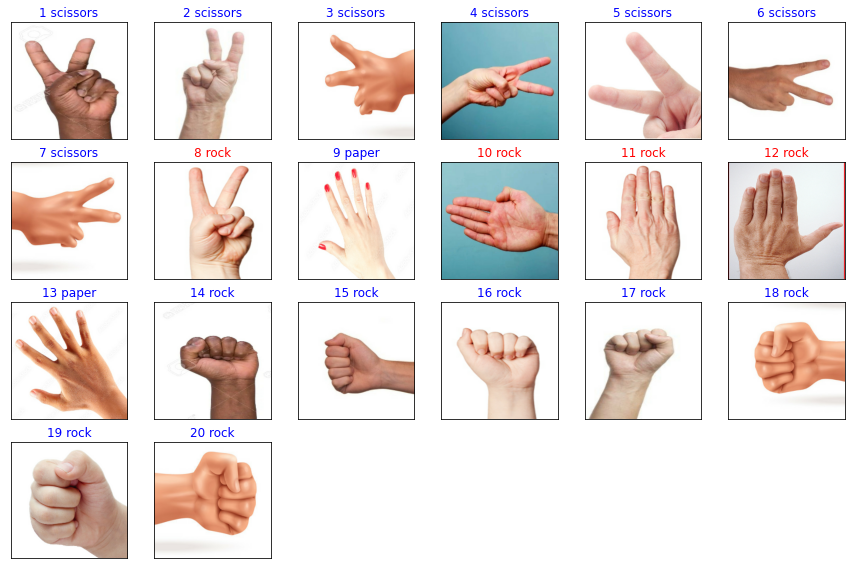

In [33]:
def do_prediction(image_folder):
    class_name=[]
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    cnt = 0
    for jdx, dir1 in enumerate(os.listdir(image_folder)):
        for idx, file in enumerate(os.listdir(os.path.join(image_folder, dir1))):
            cnt += 1
            ax = fig.add_subplot(6, 6, cnt)
            image= os.path.join(image_folder,dir1, file)
            image = tf.io.read_file(image)
            image = tf.io.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, (image_height,image_width))
            image = tf.cast(image / 255., tf.float32)
            ax.imshow(image)
            image = tf.expand_dims(image, axis=0)
            result=model.predict(tf.stack(image, axis=0))
       
            ax.set_xticks([])
            ax.set_yticks([])
            error = False if class_names[np.argmax(result)] == dir1 else True
            color = 'red' if error else 'blue'
            ax.set_title("{} {}"
              .format(cnt, class_names[np.argmax(result)]), color=color
            )   

    return
img_folder='rps_test'
do_prediction(img_folder)


**Run model.evaluate over the test dataset**

This will calculate Accuracy and Loss

The Test dataset images were collected from various sources, and are quite different from the Train and Validation image set.

Accuracy and Loss - extracted below - are indeed much worse.


In [34]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  'rps_test',
  seed=123,
  image_size=(image_height, image_width),
  batch_size=3)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

results = model.evaluate(test_ds)

print(f'Test {model.metrics_names[0]}: {results[0]}: Test {model.metrics_names[1]}: {results[1]}')



Found 20 files belonging to 3 classes.
7/7 [==============================] - 0s 14ms/step - loss: 0.3901 - accuracy: 0.8000
Test loss: 0.3900836110115051: Test accuracy: 0.800000011920929


**Coments on Inference Results**

Obviously, results with validation dataset were much better. 

There are a number of miss-classification results. A larger train dataset would probably bring better preformance, e.g. note that all papers in training dataset have gaps between fingers, and scissors images are different than those of the test dataset.


### **Inference with interactively uploaded test dataset**


---


In next notebook cell, you can interactively upload test files(s) and execute inference

Saving rock8.jpg to rock8.jpg
Saving rock7.jpg to rock7.jpg
Saving rock5.jpg to rock5.jpg


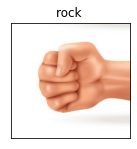

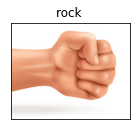

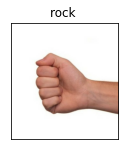

In [35]:
  uploaded = files.upload()
  cnt = 0
  for path in uploaded.keys():
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    image = tf.image.resize(img, [image_height, image_width])
    image = tf.expand_dims(image, axis=0)
    image = image / 255.0
    cnt = cnt + 1
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)

    results = model.predict(image)
    result = results[0]
    ax = fig.add_subplot(6, 6, cnt)
    ax.set_title("{} ".format(class_names[np.argmax(result)]))  
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])